## Load data

In [2]:
import os
import numpy as np
import librosa

#50 speakers audio data with length more than 1 hour for each. Wav format, 16KHz, mono channel and is split into 1min chunks. Scraped from YouTube and Librivox.
data_dir_path = '/mnt/c/Magisterka Bazy Danych/Kaggle1/50_speakers_audio_data'


def load_images(sr=16000, file_duration_sec=60) -> (np.ndarray, np.ndarray, np.ndarray):
    print("[INFO] Loading data...")
    
    file_data = []
    file_names = []
    #features = []
    labels = []
    
    speakers_count = len(os.listdir(data_dir_path))
    
    i = 0
    for speaker_dir in os.listdir(data_dir_path):
        speaker_dir_path = os.path.join(data_dir_path, speaker_dir)
        speaker_id = speaker_dir[-4:]
        if i == 51:
            break
        i=i+1
        print(f"[INFO] Loading data for user {speaker_id}...")
        numb_of_samples = 0
        for audio_file in os.listdir(speaker_dir_path):
            audio_path = os.path.join(speaker_dir_path, audio_file)
            try:
                y, sr = librosa.load(audio_path, sr=sr)
                
                # if len(features) > 0 and features[-1].shape != spect.shape:
                #     print(f"Shape of input file {audio_file} doesn't match previous one, skipping.")
                #     continue
                # 
                # features.append(spect)
                
                # load file only longer then 55 seconds
                if len(y) > 55 * sr:
                    # Apply padding so files are the same length
                    audio_length = y.shape[0]
                    pad_length = file_duration_sec*sr - audio_length
                    
                    if pad_length > 0:
                        to_insert = np.pad(y, (0, pad_length), mode='constant')
                    else:
                        to_insert = y[:file_duration*sr]  # If length matches, no padding is needed
                       
                    file_data.append(to_insert)
                        
                    file_names.append(audio_file)
                    labels.append(int(speaker_id))  # Assign label (speaker id)
                    numb_of_samples = numb_of_samples + 1
                    
                    #print(f"[DEBUG] Loading file {audio_file} with length {len(y)/sr}.")
                    
            except Exception as e:
                print(f"[ERROR] Error loading audio file: {audio_path}. Error: {e}")
        
        print(f"[INFO] Loaded a total of {numb_of_samples} samples for user {speaker_id}.")
        print(f"[INFO] [{i}/{speakers_count}] speakers loaded.")
        
    # Convert lists to numpy arrays for further processing
    #features = np.array(features)
    labels = np.array(labels)
    file_names = np.array(file_names)
    file_data = np.array(file_data)
    
    # Print the shapes to verify
    #print("Features shape:", features.shape)
    print("Audio files array shape:", file_data.shape)
    print("Labels shape:", labels.shape)
    
    #print(f"[INFO] Loaded {features.shape[0]} files.")
    print(f"[INFO] Loaded a total of {len(labels)} audio files.")
    print(f"[INFO] Used sample rate: {sr}, padded file to length of: {file_duration_sec}s.")
    
    # return features, labels, audio_data
    return file_data, labels, file_names

## Extract features

In [3]:
def extract_features(file_data, file_names, sr=16000) -> np.ndarray:
    print(f"[INFO] Extracting features...")
    features_length = len(file_data)
    features = []
    
    for i, data in enumerate(file_data):
        spect = extract_mel_spectrogram(data, sr, False)
        # spect = extract_stft_spectrogram(data, sr, False)
        # spect = extract_MFCCs(data, sr, False)
        # spect = extract_spectral_centroid(data, False)
        # spect = extract_features_means(data, sr) # 1D tests
        features.append(spect)
        
        if i%10 == 0:
            print(f"[INFO] Extracted {i}/{features_length} features.")
        
    # Convert lists to numpy arrays for further processing
    features = np.array(features)
    
    print(f"[INFO] Extracted features from {features_length} audio files.")
    
    # Print the shapes to verify
    print("Features shape:", features.shape)
        
    return features    

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import librosa

def extract_MFCCs(y, sr, show_plt: bool) -> np.ndarray:    
    # MFCC — Mel-Frequency Cepstral Coefficients
    # This feature is one of the most important method to extract a feature of an audio signal and is used majorly whenever working on audio signals. The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope.
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    
    if show_plt:
        plt.figure(figsize=(14, 5))
        librosa.display.specshow(mfccs, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
        plt.title('MFCC')
        plt.colorbar()
        plt.show() 
    
    return mfccs
    
def extract_stft_spectrogram(y, sr, show_plt: bool) -> np.ndarray:
    # Short Term Fourier Transform (STFT) converts signal such that we can know the amplitude of given frequency at a given time. 
    # It has all the frequency bands from the FFT, (n_fft/2)+1 bands, 1025 for n_fft=2048.
    stft = librosa.stft(y, hop_length=1024) # hop_length - number of audio samples between adjacent STFT columns.
    
    # You can think of a spectrogram as a bunch of FFTs stacked on top of each other. It is a way to visually represent a signal’s loudness, or amplitude, as it varies over time at different frequencies. There are some additional details going on behind the scenes when computing the spectrogram. The y-axis is converted to a log scale, and the color dimension is converted to decibels (you can think of this as the log scale of the amplitude). This is because humans can only perceive a very small and concentrated range of frequencies and amplitudes.
    spect = np.abs(stft)
    spect = librosa.amplitude_to_db(spect, ref=np.max) # Convert an amplitude spectrogram to dB-scaled spectrogram.
    
    if show_plt:
        plt.figure(figsize=(14, 5))
        librosa.display.specshow(spect, sr=sr, x_axis='time', y_axis='log')
        plt.title('Spectrogram')
        plt.colorbar(format='%+2.0f dB')
        plt.show() 
        
    return spect

def extract_mel_spectrogram(y, sr, show_plt: bool) -> np.ndarray:
    # We are better at detecting differences in lower frequencies than higher frequencies.
    # A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale.
    
    # Where-as the mel-spectrogram has mel filters applied which reduces the number of bands to n_mels (typically 32-128)
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024, n_mels=128)
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    
    if show_plt:
        plt.figure(figsize=(14, 5))
        librosa.display.specshow(mel_spect, sr=sr, y_axis='mel', fmax=8000, x_axis='time')
        plt.title('Mel Spectrogram')
        plt.colorbar(format='%+2.0f dB')
        plt.show()
        
    return mel_spect

# very high overfitting factor -> no sense
def extract_spectral_centroid(y, show_plt: bool) -> np.ndarray:
    # Spectral Centroid 
    # It indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound. If the frequencies in music are same throughout then spectral centroid would be around a centre and if there are high frequencies at the end of sound then the centroid would be towards its end.
    
    stft = librosa.stft(y, hop_length=1024) # hop_length - number of audio samples between adjacent STFT columns.
    spectrogram = np.abs(stft)
    
    spectral_centroids = librosa.feature.spectral_centroid(S=spectrogram)
    
    times = librosa.times_like(spectral_centroids)
    
    if show_plt:
        fig, ax = plt.subplots(figsize=(14, 5))
        librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),  y_axis='log', x_axis='time', ax=ax)
        
        ax.plot(times, spectral_centroids.T, label='Spectral centroid', color='w')
        ax.legend(loc='upper right')
        ax.set(title='log Power spectrogram')
        plt.show()
    
    return spectral_centroids

def extract_chroma_stft(y, sr) -> np.ndarray:
    stft = np.abs(librosa.stft(y, hop_length=1024))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    
    return chroma_stft

def extract_spectral_contrast(y, sr) -> np.ndarray:
    stft = np.abs(librosa.stft(y, hop_length=1024))
    spec_contr = librosa.feature.spectral_contrast(S=stft, sr=sr)
    
    return spec_contr

def extract_features_means(y, sr) -> np.ndarray:
    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = extract_MFCCs(y, sr, False)
    mfccs = np.mean(mfccs.T, axis=0)

    # Computes a mel-scaled spectrogram.
    mel = extract_mel_spectrogram(y, sr, False)
    mel = np.mean(mel.T, axis=0)

    # Computes spectral contrast
    spec_contr = extract_spectral_contrast(y, sr)
    spec_contr = np.mean(spec_contr.T, axis=0)

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = extract_chroma_stft(y, sr)
    chroma = np.mean(chroma.T, axis=0)

    # Computes the tonal centroid features (tonnetz)
    #tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)

    return np.concatenate((mfccs, mel, spec_contr, chroma))
    
       
       
def print_waveform(y):
    plt.figure(figsize=(14, 5))
    plt.plot(y)
    plt.title('Signal')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.show()

## Onehot encode

In [5]:
from sklearn.preprocessing import OneHotEncoder

# Perform one-hot encoding for the labels convert to one-valued arr
def onehot_encode(labels: np.ndarray) -> (np.ndarray, dict):
    print("[INFO] Performing one-hot encoding on multiple nodes...")
    # Version 2 -> n nodes
    encoder = OneHotEncoder()
    labels = np.array(labels).reshape(-1, 1)
    labels_onehot = encoder.fit_transform(labels)
    labels_onehot = labels_onehot.astype(float) # convert to float
    labels_onehot = labels_onehot.toarray()
    
    # Display the mapping between original classes and one-hot encoded columns
    original_classes = encoder.categories_[0]
    mapping = {col_idx: class_label for col_idx, class_label in enumerate(original_classes)}
    print("Mapping between column indices and original classes:")
    print(mapping)
    
    print("Labels encoded using OneHotEncoder(), labels.shape:", labels_onehot.shape)
    
    return labels_onehot, mapping

## Model evaluation

In [34]:
from scipy.interpolate import make_interp_spline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score, ConfusionMatrixDisplay

def evaluate_model(H, y_pred, y_test, n_of_epochs):
    print("[INFO] Evaluating model...")

    print(f'Type and shape of y_test: {type(y_test)} | {y_test.shape}')
    print(f'Type and shape of y_pred: {type(y_pred)} | {y_pred.shape}')
    
    print('\nConfusion matrix:') 
    print(confusion_matrix(y_test, y_pred)) 
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(conf_matrix)
    
    fig, ax = plt.subplots(figsize=(15,15))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    ax.grid(False)
    disp.plot(ax=ax)
  
    print(classification_report(y_test, y_pred, zero_division=1))
    print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred)*100:.1f}%")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.1f}%")
    
    # plots the training loss and accuracy
    epochs_x = np.arange(0, n_of_epochs)
    X_ = np.linspace(epochs_x.min(), epochs_x.max(), 250)
    
    plt.style.use("ggplot")
    plt.figure(figsize=(14,8))
    plt.subplot(2, 1, 1)
    plt.plot(X_, return_interpolated_plot(H.history["loss"][:n_of_epochs], epochs_x, X_), label="train_loss")
    plt.plot(X_, return_interpolated_plot(H.history["val_loss"][:n_of_epochs], epochs_x, X_), label="val_loss")
    plt.title("Training and validation Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    plt.show()
    
    plt.style.use("ggplot")
    plt.figure(figsize=(14,8))
    plt.subplot(2, 1, 2)
    plt.plot(X_, return_interpolated_plot(H.history["accuracy"][:n_of_epochs], epochs_x, X_), label="train_acc")
    plt.plot(X_, return_interpolated_plot(H.history["val_accuracy"][:n_of_epochs], epochs_x, X_), label="val_acc")
    
    plt.title("Training and validation Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower left")
    plt.show()
    
def return_interpolated_plot(y, x, X_):
    X_Y_Spline = make_interp_spline(x , y)
    Y_ = X_Y_Spline(X_)
 
    return Y_

## ------

In [13]:
# sample rate of the files
sr = 16000
file_duration = 60
file_data, labels, file_names = load_images(sr, file_duration)

## Create data directory if not exist

In [10]:
import numpy as np
import os

directory = 'data/'

# Check if the directory exists, and if not, create it
if not os.path.exists(directory):
    os.makedirs(directory)


## Optional: save files on disk

In [ ]:
# Assuming you have your file_data, labels, and file_names arrays
# Save arrays to disk
np.save(os.path.join(directory, 'file_data.npy'), file_data)
np.save(os.path.join(directory, 'labels.npy'), labels)
np.save(os.path.join(directory, 'file_names.npy'), file_names)

## Optional: load data

In [11]:
import numpy as np

# Load arrays from disk
file_data = np.load(os.path.join(directory, 'file_data.npy'))
labels = np.load(os.path.join(directory, 'labels.npy'))
file_names = np.load(os.path.join(directory, 'file_names.npy'))

In [14]:
# cut the files to reduce parameters size and compute model
print(f"[DEBUG] Audio files length before truncating: {file_data.shape[1]/sr:.2f}s.")
# print(f"[DEBUG] Audio files data before truncating: {file_data.shape}.")
truncated_file_data = file_data[:, :30*sr]
print(f"[INFO] Audio files length after truncating: {truncated_file_data.shape[1]/sr:.2f}s.")
# print(f"[DEBUG] Audio files data before truncating: {truncated_file_data.shape}.")

[DEBUG] Audio files length before truncating: 60.00s.
[INFO] Audio files length after truncating: 30.00s.


In [15]:
features = extract_features(truncated_file_data, file_names, sr)

[INFO] Extracting features...
[INFO] Extracted 0/2465 features.
[INFO] Extracted 10/2465 features.
[INFO] Extracted 20/2465 features.
[INFO] Extracted 30/2465 features.
[INFO] Extracted 40/2465 features.
[INFO] Extracted 50/2465 features.
[INFO] Extracted 60/2465 features.
[INFO] Extracted 70/2465 features.
[INFO] Extracted 80/2465 features.
[INFO] Extracted 90/2465 features.
[INFO] Extracted 100/2465 features.
[INFO] Extracted 110/2465 features.
[INFO] Extracted 120/2465 features.
[INFO] Extracted 130/2465 features.
[INFO] Extracted 140/2465 features.
[INFO] Extracted 150/2465 features.
[INFO] Extracted 160/2465 features.
[INFO] Extracted 170/2465 features.
[INFO] Extracted 180/2465 features.
[INFO] Extracted 190/2465 features.
[INFO] Extracted 200/2465 features.
[INFO] Extracted 210/2465 features.
[INFO] Extracted 220/2465 features.
[INFO] Extracted 230/2465 features.
[INFO] Extracted 240/2465 features.
[INFO] Extracted 250/2465 features.
[INFO] Extracted 260/2465 features.
[INFO] Ex

[INFO] Plotting sample fragments of extracted features...


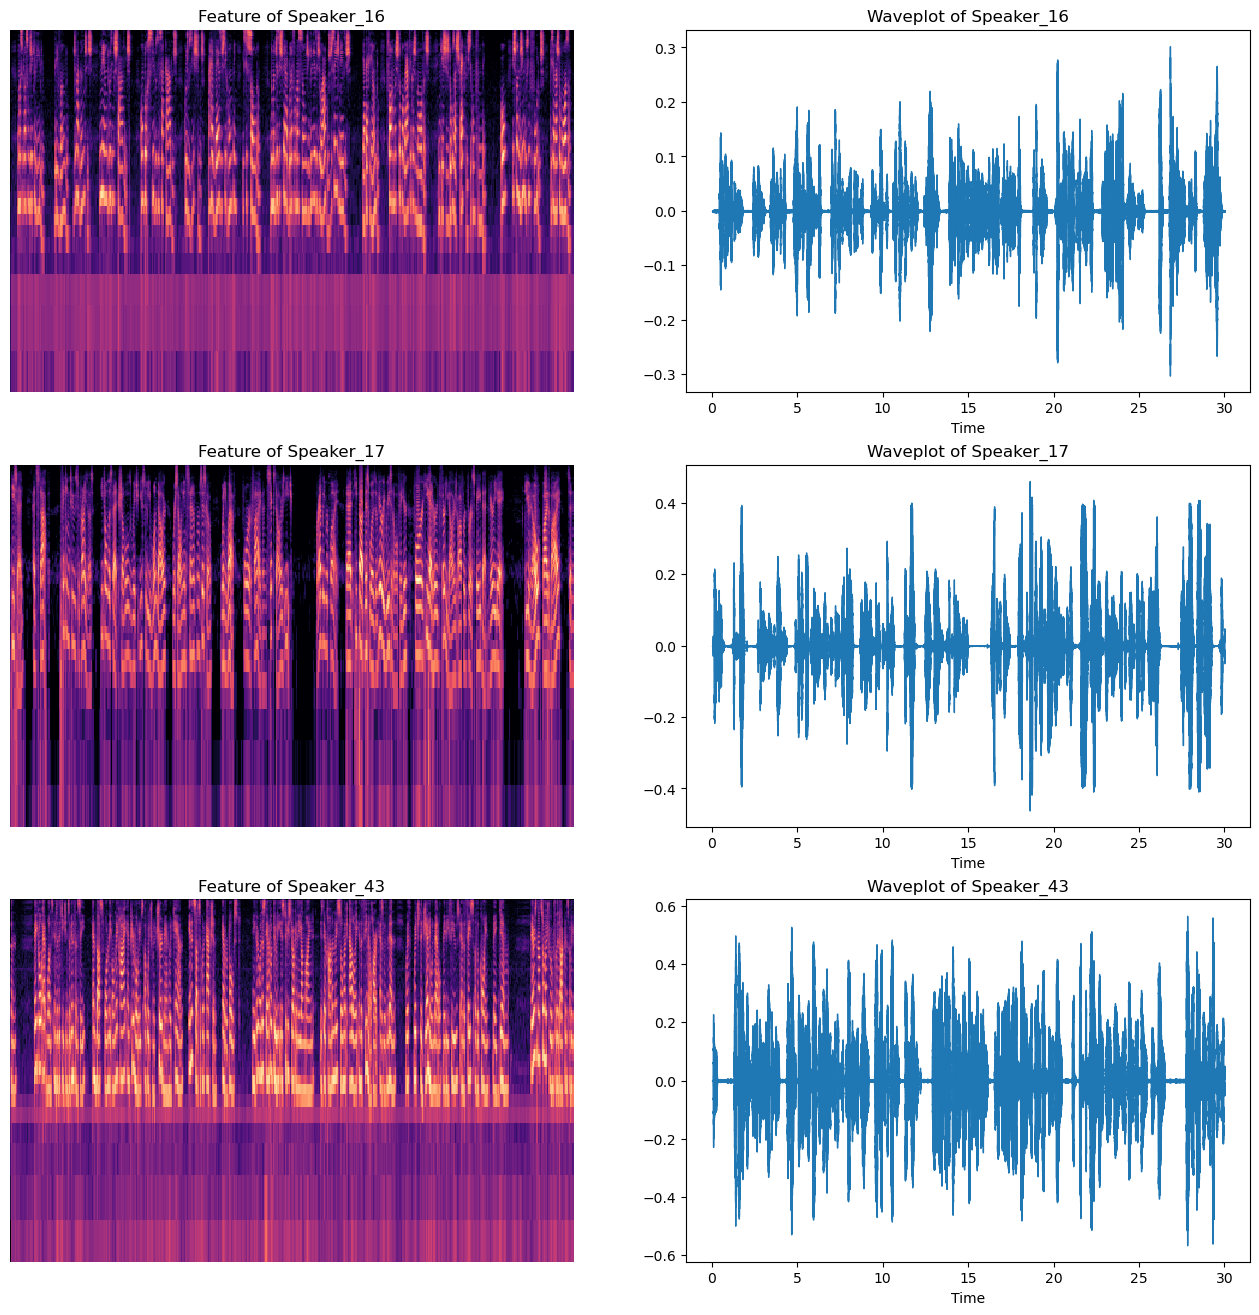

In [17]:
import random

print("[INFO] Plotting sample fragments of extracted features...")

plt.figure(figsize=(16, 16))

for i in range(3):
    n = random.randrange(len(features))
    plt.subplot(3, 2, 2*i + 1)
    librosa.display.specshow(features[n], sr=sr, x_axis='time', y_axis='log')
    plt.title(f'Feature of Speaker_{labels[n]}')
    plt.axis("off")
    
    plt.subplot(3, 2, 2*i + 2)
    librosa.display.waveshow(truncated_file_data[n], sr=sr)
    plt.title(f'Waveplot of Speaker_{labels[n]}')


## Encode Labels

In [18]:
labels_onehot, class_onehot_mapping = onehot_encode(labels)

[INFO] Performing one-hot encoding on multiple nodes...
Mapping between column indices and original classes:
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 23, 23: 24, 24: 25, 25: 26, 26: 27, 27: 28, 28: 29, 29: 30, 30: 31, 31: 32, 32: 33, 33: 34, 34: 35, 35: 36, 36: 37, 37: 38, 38: 39, 39: 40, 40: 41, 41: 42, 42: 43, 43: 44, 44: 45, 45: 46, 46: 47, 47: 48, 48: 49, 49: 50}
Labels encoded using OneHotEncoder(), labels.shape: (2465, 50)


## Split train and test data

In [19]:
from sklearn.model_selection import train_test_split

# train:test 70:30
X_train, X_test, y_train, y_test = train_test_split(features, labels_onehot, test_size=0.30, random_state=32)

# test:val 40:60
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.60, random_state=32)

# train: 70%, val: 18%, test: 12%


# Calculate the count of each class in the training set
train_class_counts = np.sum(y_train, axis=0)
train_class_dict = {f"Class {i}": count for i, count in enumerate(train_class_counts)}

# Calculate the count of each class in the validation set
val_class_counts = np.sum(y_val, axis=0)
val_class_dict = {f"Class {i}": count for i, count in enumerate(val_class_counts)}

# Calculate the count of each class in the test set
test_class_counts = np.sum(y_test, axis=0)
test_class_dict = {f"Class {i}": count for i, count in enumerate(test_class_counts)}

# Calculate the total number of samples in each set
total_train_samples = np.sum(train_class_counts)
total_val_samples = np.sum(val_class_counts)
total_test_samples = np.sum(test_class_counts)

# Print the class counts and percentages for each set aligned by class
max_len = max(len(key) for key in train_class_dict.keys())

print("Class".ljust(max_len + 5), "Train".ljust(15), "Validation".ljust(15), "Test".ljust(15))
print("-" * (max_len + 5 + 15 + 15 + 15))

for key in train_class_dict:
    percent_train = (train_class_dict[key] / total_train_samples) * 100
    percent_val = (val_class_dict[key] / total_val_samples) * 100
    percent_test = (test_class_dict[key] / total_test_samples) * 100

    print(key.ljust(max_len + 5),
          f"{train_class_dict[key]} ({percent_train:.2f}%)".ljust(15),
          f"{val_class_dict[key]} ({percent_val:.2f}%)".ljust(15),
          f"{test_class_dict[key]} ({percent_test:.2f}%)".ljust(15))

print(f'\nShape of the training set: {X_train.shape}')
print(f'Shape of the validation set: {X_val.shape}')
print(f'Shape of the test set: {X_test.shape}')

Class         Train           Validation      Test           
----------------------------------------------------------
Class 0       71.0 (4.12%)    15.0 (3.38%)    7.0 (2.36%)    
Class 1       74.0 (4.29%)    28.0 (6.31%)    15.0 (5.07%)   
Class 2       78.0 (4.52%)    25.0 (5.63%)    16.0 (5.41%)   
Class 3       56.0 (3.25%)    16.0 (3.60%)    12.0 (4.05%)   
Class 4       62.0 (3.59%)    16.0 (3.60%)    11.0 (3.72%)   
Class 5       47.0 (2.72%)    15.0 (3.38%)    9.0 (3.04%)    
Class 6       48.0 (2.78%)    13.0 (2.93%)    14.0 (4.73%)   
Class 7       43.0 (2.49%)    16.0 (3.60%)    2.0 (0.68%)    
Class 8       72.0 (4.17%)    15.0 (3.38%)    11.0 (3.72%)   
Class 9       40.0 (2.32%)    10.0 (2.25%)    14.0 (4.73%)   
Class 10      36.0 (2.09%)    10.0 (2.25%)    7.0 (2.36%)    
Class 11      42.0 (2.43%)    15.0 (3.38%)    7.0 (2.36%)    
Class 12      28.0 (1.62%)    2.0 (0.45%)     3.0 (1.01%)    
Class 13      23.0 (1.33%)    8.0 (1.80%)     5.0 (1.69%)    
Class 14   

## Build a CNN model

In [27]:
from keras.layers import LeakyReLU
from keras.src.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

feature_width, feature_height = X_train.shape[1:3]

classes = y_train.shape[1]

# Build the CNN model
model = Sequential([
    # This layer extracts 64 different 3x3 features
    # Typically you’ll see strides of 2×2 as a replacement to max pooling:
    Conv2D(64, (3, 3), input_shape=(feature_width, feature_height, 1), padding="same", activation='relu'),
    Conv2D(64, (3, 3), strides=(4, 4), padding="same", activation='relu'),
    Dropout(0.25), # Dropout helps generalize and not overfit. Neurons from the current layer, with probability p, will randomly disconnect from neurons in the next layer so that the network has to rely on the existing connections.
     
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Conv2D(128, (3, 3), strides=(4, 4), padding='same', activation='relu'),
    Dropout(0.25),
     
    Flatten(),
    
    #So you should add BN after your convolutions and then you should also remove DropOut. It has been studied by many researchers that Dropout is not needed if BN is used and BN performs actually better.
    
    # # Use ReLU to avoid vanishing gradients problem
    # next step -> RELU to LEAKY RELU 
    # The main advantage of using Leaky ReLU over normal ReLU is that it helps to overcome the "dying ReLU" problem. The dying ReLU problem occurs when the neuron stops responding to the input because its output is consistently negative due to the ReLU function. Leaky ReLU solves this problem by allowing a small positive output for negative inputs, which ensures that the neuron remains active even when the input is negative. Additionally, Leaky ReLU can help to improve the performance of deep neural networks by allowing them to learn more complex features and reducing the likelihood of overfitting.
    
    #Now, think about the chain rule in the backward pass. If the derivative of the slope of the ReLU is of 0, absolutely no learning is performed on the layers below the dead ReLU, because 0 will be multiplied to the accumulated gradient for the weight update. Thus, you can have dead neurons. This problem doesn’t happen with LReLU or ELU for example, they will always have a little slope to allow the gradients to flow on.
    
    #Dense(1024, activation='relu'),
    #Dropout(0.25),
    
    Dense(1024, activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    #Dropout(0.25),
    
    #Dense(512, activation='relu'),
    #Dropout(0.25),
    
    Dense(512, activation=LeakyReLU(alpha=0.01)),
    BatchNormalization(),
    #Dropout(0.25),
    
    # Dense(256, activation='relu'),
    # Dropout(0.25)
    
    Dense(256, activation=LeakyReLU(alpha=0.01)),
    BatchNormalization(), # adding this normalization (and removing dropout) resulted in model learning faster (on train_acc, val_acc also grows faster but with delay 3-4 epoch)
    #Dropout(0.25),
    
    # In the Ioffe and Szegedy 2015, the authors state that "we would like to ensure that for any parameter values, the network always produces activations with the desired distribution". So the Batch Normalization Layer is actually inserted right after a Conv Layer/Fully Connected Layer, but before feeding into ReLu (or any other kinds of) activation
    
    # So in summary, the order of using batch normalization and dropout is:
    # -> CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout -> CONV/FC ->
    
    
    #using a drop outs to avoid stepping to local minimums and labeling all samples to one class

    Dense(classes, activation='softmax'), # in general the best result are produced with softmax
    #sigmoid in some cases performs better and prevent stucking in the loss function local minimals
    # Categorical Classification: using softmax - multiple output nodes
    
    #If you have a multi-label classification problem = there is more than one "right answer" = the outputs are NOT mutually exclusive, then use a !!!sigmoid function!!! on each raw output independently. The sigmoid will allow you to have high probability for all of your classes, some of them, or none of them. Example: classifying diseases in a chest x-ray image. The image might contain pneumonia, emphysema, and/or cancer, or none of those findings.
    
    #If you have a multi-class classification problem = there is only one "right answer" = the outputs are mutually exclusive, then use a !!!softmax function!!!. The softmax will enforce that the sum of the probabilities of your output classes are equal to one, so in order to increase the probability of a particular class, your model must correspondingly decrease the probability of at least one of the other classes. Example: classifying images from the MNIST data set of handwritten digits. A single picture of a digit has only one true identity - the picture cannot be a 7 and an 8 at the same time.
])

# Tldr; I’ve seen a good rule-of-thumb is about 14-18x times the model size for memory limits, so for a 10GB card, training your model would max out memory at roughly 540M parameters.
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 469, 64)      640       
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 118, 64)       36928     
                                                                 
 dropout_9 (Dropout)         (None, 32, 118, 64)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 118, 128)      73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 30, 128)        147584    
                                                                 
 dropout_10 (Dropout)        (None, 8, 30, 128)        0         
                                                                 
 flatten_3 (Flatten)         (None, 30720)            

In [28]:
from keras.src.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras

#todo
#If the accuracy is not changing, it means the optimizer has found a local minimum for the loss. This may be an undesirable minimum. One common local minimum is to always predict the class with the most number of data points. You should use weighting on the classes to avoid this minimum.
#from sklearn.utils import compute_class_weight
#classWeight = compute_class_weight('balanced', outputLabels, outputs) 
#classWeight = dict(enumerate(classWeight))
#model.fit(X_train, y_train, batch_size = batch_size, nb_epoch = nb_epochs, show_accuracy = True, verbose = 2, validation_data = (X_test, y_test), class_weight=classWeight)

#^^^ 
# Another approach is to use a weighted cross entropy (for example, you could compute the cross entropy for each sample, and multiply it with a weight (to be exact, a Tensor of weights for each sample); only after this should you apply tf.reduce_mean. You could, for example, apply a larger weight to the class containing fewer samples, and thus force the optimizer to pay more attention to these samples.
# weights = tf.placeholder(tf.float32, shape=[None])
#loss = tf.reduce_mean(tf.multiply(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = y_conv), weights))

# faced same problem for multi-class, Try to changing optimizer by default it is Adam change it to sgd.

opt = keras.optimizers.Adam(learning_rate=0.0005)
# crossentropy - Probabilistic losses
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

#checkpoint = ModelCheckpoint('best_model_256.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# 1. *batch size* - defines the number of samples that will be propagated through the network. default 32
# one epoch = one forward pass and one backward pass of all the training examples batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
# number of iterations = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes). 
# in model.fit the default batch size is 32. So if you have 7000 samples then the steps per epoch is 7000/32=218.75 which gets rounded up to 219. So what this means is to go through your 7000 samples it fetches 32 images for each batch and does that 219 times.
epochs=30

# saving the best epoch score model to file
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

H = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint]) 

stopped_epoch = early_stopping.stopped_epoch

Epoch 1/30


2023-11-27 19:58:15.973733: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


54/54 [==============================] - 5s 54ms/step - loss: 3.4966 - accuracy: 0.1455 - val_loss: 44.5647 - val_accuracy: 0.0158
Epoch 2/30
54/54 [==============================] - 2s 32ms/step - loss: 1.4036 - accuracy: 0.6365 - val_loss: 13.3392 - val_accuracy: 0.0113
Epoch 3/30
54/54 [==============================] - 2s 42ms/step - loss: 0.2977 - accuracy: 0.9420 - val_loss: 7.6112 - val_accuracy: 0.0518
Epoch 4/30
54/54 [==============================] - 2s 42ms/step - loss: 0.0923 - accuracy: 0.9884 - val_loss: 6.9950 - val_accuracy: 0.0631
Epoch 5/30
54/54 [==============================] - 2s 42ms/step - loss: 0.0430 - accuracy: 0.9971 - val_loss: 2.3613 - val_accuracy: 0.3784
Epoch 6/30
54/54 [==============================] - 2s 42ms/step - loss: 0.0295 - accuracy: 0.9977 - val_loss: 1.8936 - val_accuracy: 0.4707
Epoch 7/30
54/54 [==============================] - 2s 44ms/step - loss: 0.0163 - accuracy: 1.0000 - val_loss: 0.6884 - val_accuracy: 0.8221
Epoch 8/30
54/54 [====

10/10 [==============================] - 0s 24ms/step
Predicted | Actual |  Confidence   |
   2      |   2    |    99.16   %  |  ✔ 
   42     |   42   |    87.30   %  |  ✔ 
   29     |   29   |    99.94   %  |  ✔ 
   1      |   1    |    99.97   %  |  ✔ 
   40     |   40   |    64.41   %  |  ✔ 
   4      |   4    |    98.81   %  |  ✔ 
   8      |   8    |    99.95   %  |  ✔ 
   48     |   48   |    99.90   %  |  ✔ 
   33     |   33   |    99.55   %  |  ✔ 
   4      |   0    |    99.23   %  |  ✘ 
   38     |   38   |    77.80   %  |  ✔ 
   21     |   21   |    99.85   %  |  ✔ 
   24     |   24   |    99.62   %  |  ✔ 
   40     |   40   |    96.96   %  |  ✔ 
   29     |   29   |    99.89   %  |  ✔ 
   9      |   9    |    99.58   %  |  ✔ 
   12     |   12   |    98.93   %  |  ✔ 
   21     |   21   |    99.99   %  |  ✔ 
   48     |   48   |    99.93   %  |  ✔ 
   8      |   8    |    99.21   %  |  ✔ 
   48     |   48   |    99.87   %  |  ✔ 
   9      |   9    |    99.87   %  |  ✔ 
   26  

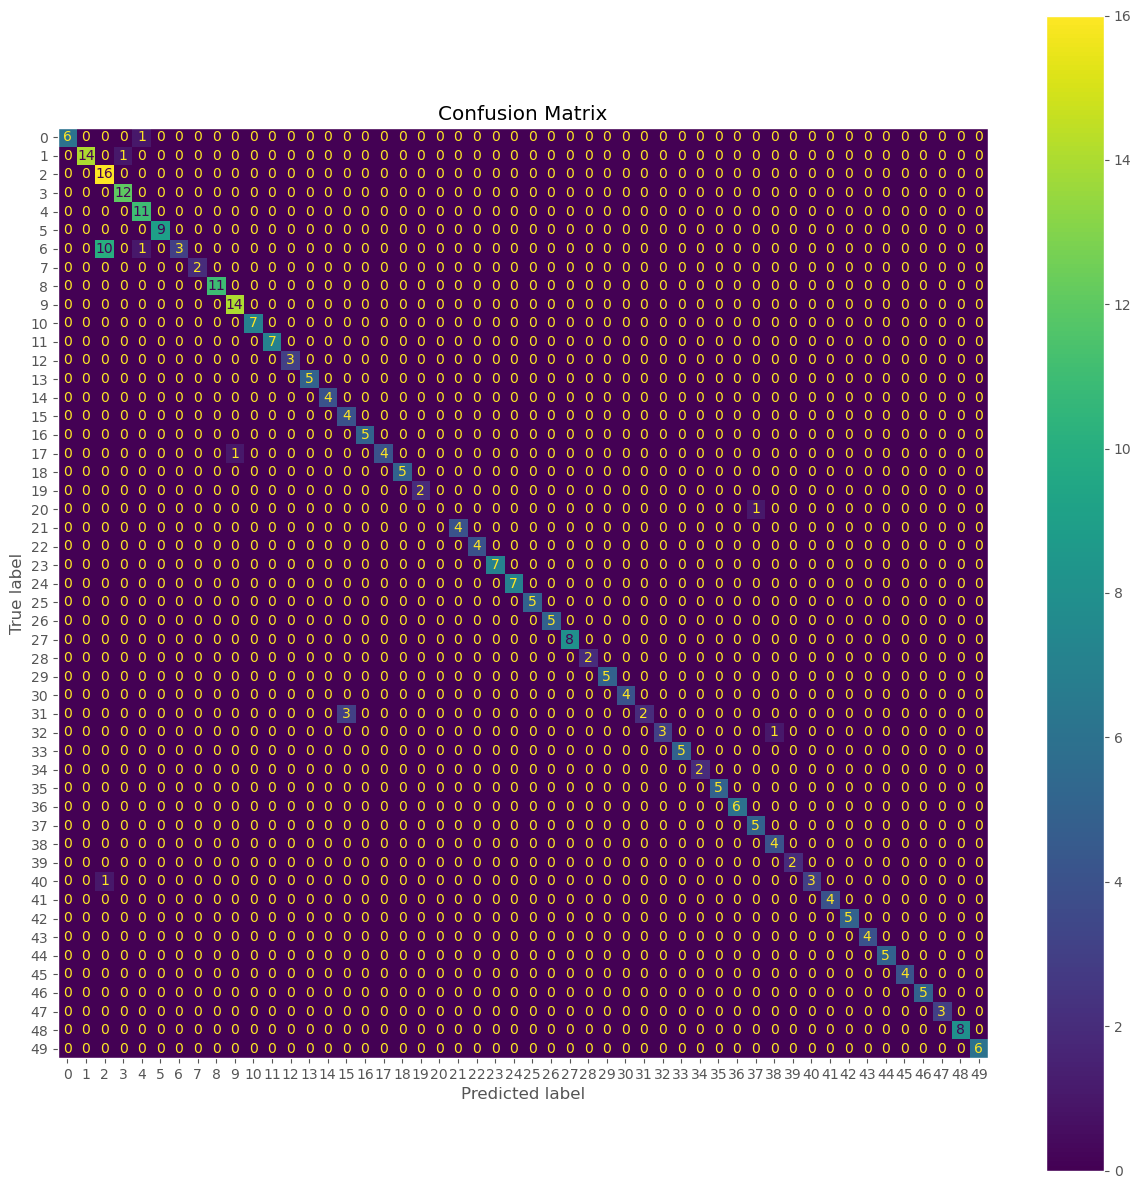

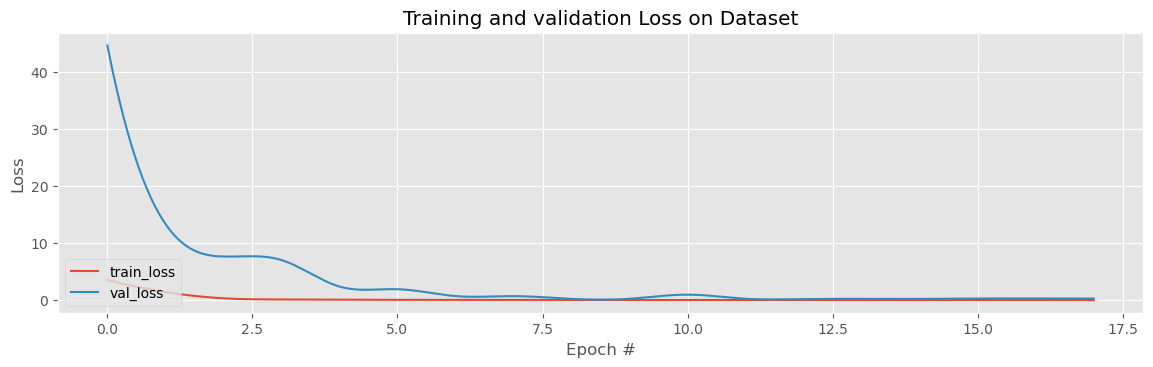

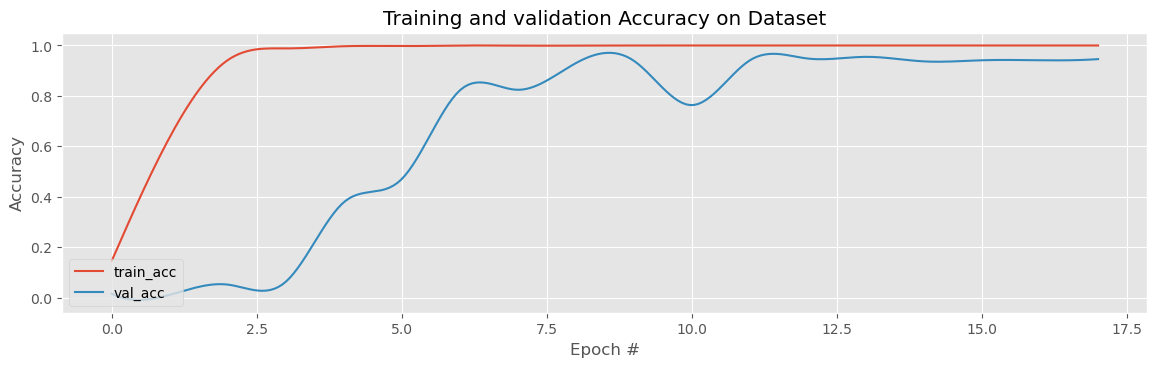

In [35]:
y_pred = model.predict(X_test)

y_pred_confidence = np.max(y_pred, axis=1)


y_pred = np.argmax(y_pred, axis=1) # softmax predictions need to be rounded 
y_pred = np.array(y_pred.tolist()) 

if y_pred.shape != y_test.shape:
    y_test = np.argmax(y_test, axis=1) 
    y_test = np.array(y_test.tolist()) 


print('Predicted | Actual |  Confidence   |')
for i in range(0, len(y_pred)):
    correct = '✔' if y_pred[i] == y_test[i] else '✘'
    print(f'{y_pred[i]:^8}  |  {y_test[i]:^4}  |  {y_pred_confidence[i]*100:^10.2f}%  |  {correct:^2}')
        

evaluate_model(H, y_pred, y_test, stopped_epoch)

## Load best model

In [5]:
from tensorflow.python.keras.models import load_model
from tensorflow import keras

#Keras saves models by inspecting their architectures. This technique saves everything:
#The weight values
#The model's architecture
#The model's training configuration (what you pass to the .compile() method)
#The optimizer and its state, if any (this enables you to restart training where you left off)
#Keras is not able to save the v1.x optimizers (from tf.compat.v1.train) since they aren't compatible with checkpoints. For v1.x optimizers, you need to re-compile the model after loading—losing the state of the optimizer.

model = load_model('best_model.h5', compile=False)